### Steps involved in model building:
1. Splitting the data into train and test
2. Preprocessing 
3. Fitting a model
4. Evaluating the performance

In [88]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import mlflow


In [89]:
df = pd.read_excel('./Data/2410_iPAGE_SoilData_original.xlsx')
df.columns

Index(['Area', 'soil group', 'Land class', 'knit (surface)', 'pH', 'SOC (%)',
       'Nitrogen N (%)', 'Potassium K (meq/100)', 'Phosphorus P (ug/g)',
       'Sulfur S (ug/g)', 'Boron B (ug/g)', 'Zinc Zn (ug/g)'],
      dtype='object')

In [90]:
# converting all the 'non numerical' values in the numerical columns to NaN
for i in range(4,len(df.columns)):
    df[df.columns[i]] = pd.to_numeric(df[df.columns[i]],errors='coerce')

In [91]:
df.columns[4:]

Index(['pH', 'SOC (%)', 'Nitrogen N (%)', 'Potassium K (meq/100)',
       'Phosphorus P (ug/g)', 'Sulfur S (ug/g)', 'Boron B (ug/g)',
       'Zinc Zn (ug/g)'],
      dtype='object')

In [92]:
# Now we drop the rows with NaN, but we also have text columns with NaN values, which we are avoiding here
print(df.shape)
df = df.dropna(subset=df.columns[4:])
print(df.shape)


(618, 12)
(581, 12)


#### Inputs to the model : 
       'Area', 'soil group', 'Land class', 'knit (surface)', 'pH', ,
       'Nitrogen N (%)', 'Potassium K (meq/100)', 'Phosphorus P (ug/g)',
       'Sulfur S (ug/g)'
#### Outputs from the model : 
        'SOC (%)','Boron B (ug/g)', 'Zinc Zn (ug/g)'

In [93]:
## Train test split

X = df[['Area', 'soil group', 'Land class', 'knit (surface)', 'pH',
       'Nitrogen N (%)', 'Potassium K (meq/100)', 'Phosphorus P (ug/g)',
       'Sulfur S (ug/g)']]
y = df[['SOC (%)','Boron B (ug/g)', 'Zinc Zn (ug/g)']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)



(464, 9) (464, 3)
(117, 9) (117, 3)


#### Preprocessing

In [94]:
### Preprocessing step


In [95]:
mlflow.set_experiment('first exp')

<Experiment: artifact_location='file:///Users/jamsheedakadengal/Desktop/Omdena/IPAGE/notebooks/task_3_model_development_and_training/by-Jamsheeda/mlruns/671194069552090611', creation_time=1730896677286, experiment_id='671194069552090611', last_update_time=1730896677286, lifecycle_stage='active', name='first exp', tags={}>

#### Baseline model :
In order to have an understanding of the performance of our model, it is important to have a baseline model. Here I am taking the average of the values in the training set as the prediction.
ie, the prediction for Boron is the average of the Boron values in the training set

In [96]:
# creating a prediction dataframe with the mean values from training data
with mlflow.start_run(description="mean of target columns in training dataset"):
    y_predict_baseline = pd.DataFrame().reindex_like(y_test)
    y_predict_baseline.iloc[0]=y_train.mean()
    y_predict_baseline = y_predict_baseline.ffill()
    r2_baseline = r2_score(y_test,y_predict_baseline)
    mape_baseline = mean_absolute_percentage_error(y_pred=y_predict_baseline,y_true=y_test)
    print(mape_baseline)
    mlflow.log_params({"model":"mean of target columns in training dataset"})
    mlflow.log_metrics({"R2":r2_baseline,"MAPE":mape_baseline})

0.6406958904498251


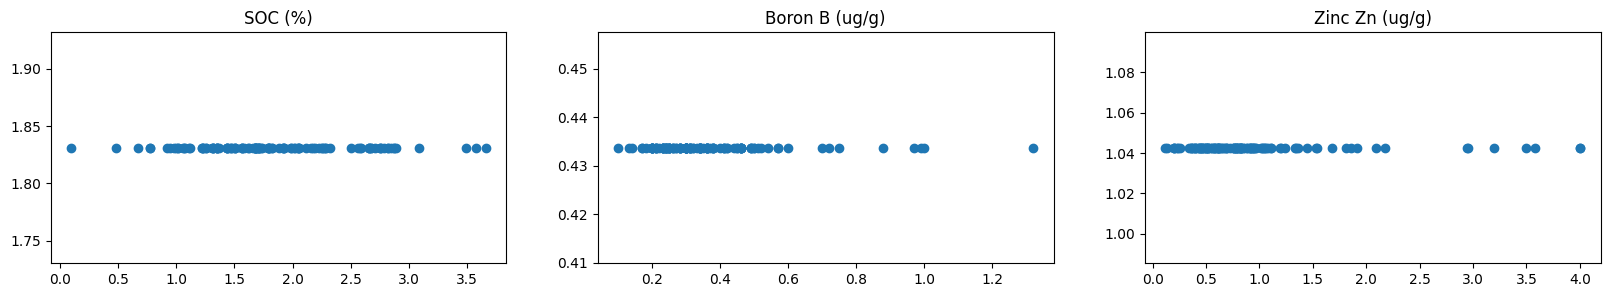

In [97]:
#plotting the predictions vs true for baseline
plt.rcParams["figure.figsize"] = (20,3)
figure, axis = plt.subplots(1, 3)

for i in range(3):
    axis[i].scatter(y_test[y_test.columns[i]],y_predict_baseline[y_test.columns[i]])
    axis[i].set_title(y_test.columns[i])

#### Random forest regressor

In [98]:
# A random forest regressor trained on only the numeric columns of the training data
with mlflow.start_run(description="Random forest with only numerical columns"):
    model = RandomForestRegressor().fit(X=X_train.iloc[:,4:],y=y_train)
    y_predict = model.predict(X_test.iloc[:,4:])
    r2 = r2_score(y_test,y_predict)
    mape = mean_absolute_percentage_error(y_pred=y_predict,y_true=y_test)
    print('r2 : ',r2)
    print('MAPE: ',mape)
    mlflow.log_params({"model":"Random forest with only numerical columns"})
    mlflow.log_metrics({"R2":r2,"MAPE":mape})

r2 :  -4.400441506778435
MAPE:  0.5769010005024895


In [99]:
# feature importance
pd.Series(data=model.feature_importances_,index=X_train.columns[4:])

pH                       0.101375
Nitrogen N (%)           0.149368
Potassium K (meq/100)    0.149138
Phosphorus P (ug/g)      0.236684
Sulfur S (ug/g)          0.363435
dtype: float64

In [100]:
# A ridge regressor trained on only the numeric columns of the training data
from sklearn.linear_model import LinearRegression
with mlflow.start_run(description="Linear regressor with only numerical columns"):
    model = LinearRegression().fit(X=X_train.iloc[:,4:],y=y_train)
    y_predict = model.predict(X_test.iloc[:,4:])
    r2 = r2_score(y_test,y_predict)
    mape = mean_absolute_percentage_error(y_pred=y_predict,y_true=y_test)
    print('r2 : ',r2)
    print('MAPE: ',mape)
    mlflow.log_params({"model":"Linear regressor with only numerical columns"})
    mlflow.log_metrics({"R2":r2,"MAPE":mape})

r2 :  0.014875978649261637
MAPE:  0.6167393516641692


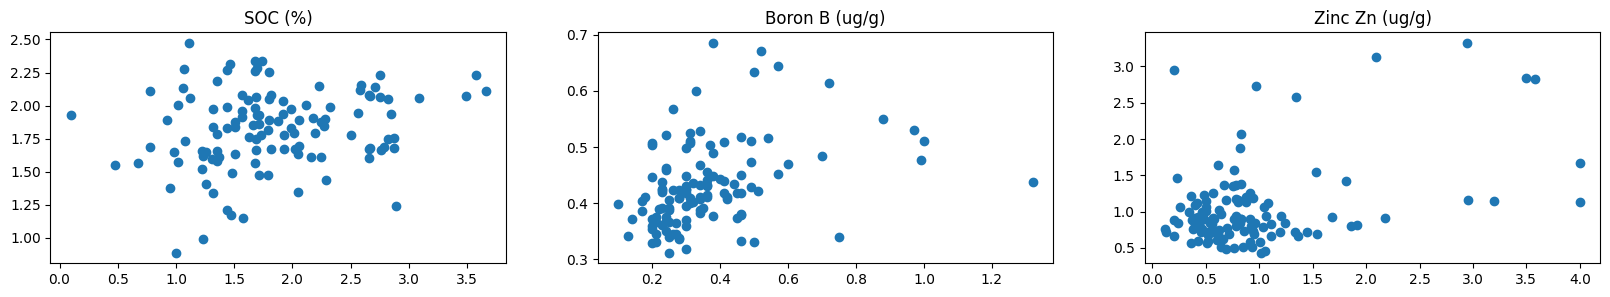

In [101]:
# Initialise the subplot function using number of rows and columns
plt.rcParams["figure.figsize"] = (20,3)
figure, axis = plt.subplots(1, 3)

for i in range(3):
    axis[i].scatter(y_test[y_test.columns[i]],y_predict[:,i])
    axis[i].set_title(y_test.columns[i])

#### Random Forest Regressor including the text columns

In [102]:
# Preprocessing Label encoder
# There are 5 unique 'Area', 27 unique 'Soil group',5 unique 'Land class' and 5 unique knit (surface)
# SInce there are about 164 NaNs in knit (surface) , we are not considering it at the moment
# Using Labelencoder for encoding
from sklearn.preprocessing import LabelEncoder
for i in range(3):
    le = LabelEncoder()
    # Fit and transform the target variable
    X_train.iloc[:,i] = le.fit_transform(X_train.iloc[:,i])
    #X_test.iloc[:,i] = le.transform(X_test.iloc[:,i])
    X_test.iloc[:,i] = X_test.iloc[:,i].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    X_test.iloc[:,i] = le.transform(X_test.iloc[:,i])


In [103]:
X_train.head()

,Area,soil group,Land class,knit (surface),pH,Nitrogen N (%),Potassium K (meq/100),Phosphorus P (ug/g),Sulfur S (ug/g)
462,1,5,1,loam,5.7,0.11,0.11,16.38,11.09
210,2,8,1,Clay loam,6.1,0.14,0.17,6.20,14.70
186,2,5,1,loam,5.3,0.16,0.06,4.00,20.30
179,2,5,1,loam,4.9,0.11,0.10,13.20,10.50
194,2,9,1,loam,5.4,0.14,0.07,17.00,35.70


In [104]:
X_test.head()

,Area,soil group,Land class,knit (surface),pH,Nitrogen N (%),Potassium K (meq/100),Phosphorus P (ug/g),Sulfur S (ug/g)
612,4,24,1,NaN,5.4,0.11,0.17,30.00,11.00
280,3,5,4,loam,5.2,0.11,0.08,8.40,1.20
105,2,13,4,loam,5.2,0.07,0.29,16.80,5.00
478,1,6,1,loam clay,5.8,0.09,0.16,15.57,9.51
463,1,5,1,loam,5.0,0.10,0.13,14.51,8.94


In [105]:
# for RF model

with mlflow.start_run(description="Random forest with numerical columns,Area,soil group and Land class"):
    model = RandomForestRegressor().fit(X=X_train.drop(columns=['knit (surface)']),y=y_train)
    y_predict = model.predict(X_test.drop(columns=['knit (surface)']))
    r2 = r2_score(y_test,y_predict)
    mape = mean_absolute_percentage_error(y_pred=y_predict,y_true=y_test)
    print('R2 : ',r2)
    print('MAPE: ',mape)
    mlflow.log_params({"model":"Random forest with numerical columns,Area,soil group and Land class"})
    mlflow.log_metrics({"R2":r2,"MAPE":mape})


R2 :  -5.213711515400109
MAPE:  0.5428100648943309


In [106]:
from sklearn.linear_model import LinearRegression
with mlflow.start_run(description="Linear regressor with only numerical columns and area, soil group and land class"):
    model = LinearRegression().fit(X=X_train.drop(columns=['knit (surface)']),y=y_train)
    y_predict = model.predict(X_test.drop(columns=['knit (surface)']))
    r2 = r2_score(y_test,y_predict)
    mape = mean_absolute_percentage_error(y_pred=y_predict,y_true=y_test)
    print('r2 : ',r2)
    print('MAPE: ',mape)
    mlflow.log_params({"model":"Linear regressor with only numerical columns and area, soil group and land class"})
    mlflow.log_metrics({"R2":r2,"MAPE":mape})

r2 :  0.005656615214409484
MAPE:  0.589140421129096
